In [1]:
#| code-fold: true
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pymc as pm
import pytensor.tensor as pt

c_orange = "#f08533"
c_blue = "#3b78b0"
c_red = "#d1352c"

Mientras *scrapeaba* datos sobre los tiros libres de los *rookies* en la NBA durante la temporada 2024-25, me encontré con [este artículo](https://link.springer.com/article/10.1007/s12662-020-00646-x), donde se concluye que existe un efecto de “precalentamiento”: los jugadores de básquet tienden a fallar más los primeros disparos que el resto. El hallazgo me pareció interesante y lógico, y empecé a preguntarme si valía la pena realizar un análisis similar con los datos que estaba recolectando.
Y bueno, acá estamos.

## Los datos

El siguiente *data frame* contiene información sobre los tiros libres realizados por los *rookies* de la temporada 2024-25 de la NBA.
En este caso, las columnas relevantes son la identificación del jugador (`player_id`), el orden del disparo (`description`) y si el lanzamiento fue convertido (`success`).

In [2]:
df = (
    pl.read_parquet("../data.parquet")
    .select("game_date", "matchup", "player_id", "player_name", "description", "success")
)
df

game_date,matchup,player_id,player_name,description,success
date,str,i32,str,str,bool
2025-04-05,"""MEM @ DET""",1641744,"""Edey, Zach""","""Free Throw 1 of 2""",false
2025-04-05,"""MEM @ DET""",1641744,"""Edey, Zach""","""Free Throw 2 of 2""",false
2025-01-18,"""PHI @ IND""",1641737,"""Bona, Adem""","""Free Throw 1 of 1""",true
2025-01-18,"""PHI @ IND""",1641737,"""Bona, Adem""","""Free Throw 1 of 2""",false
2025-01-18,"""PHI @ IND""",1641737,"""Bona, Adem""","""Free Throw 2 of 2""",true
…,…,…,…,…,…
2024-11-06,"""MEM vs. LAL""",1642530,"""Kawamura, Yuki""","""Free Throw 1 of 2""",true
2024-11-06,"""MEM vs. LAL""",1642530,"""Kawamura, Yuki""","""Free Throw 2 of 2""",true
2025-03-12,"""MEM vs. UTA""",1641744,"""Edey, Zach""","""Free Throw 1 of 1""",false


En la NBA, los tiros libres pueden darse en series de 1, 2 o 3 intentos. Nuestra primera tarea es mapear los valores de `description` a un valor numérico que represente el orden del disparo dentro de su serie.

In [3]:
throw_order = {
    "Free Throw 1 of 1": 1,
    "Free Throw 1 of 2": 1,
    "Free Throw 1 of 3": 1,
    "Free Throw 2 of 2": 2,
    "Free Throw 2 of 3": 2,
    "Free Throw 3 of 3": 3,
    "Free Throw Clear Path 1 of 2": 1,
    "Free Throw Clear Path 2 of 2": 2,
    "Free Throw Flagrant 1 of 1": 1,
    "Free Throw Flagrant 1 of 2": 1,
    "Free Throw Flagrant 2 of 2": 2,
    "Free Throw Technical": 1,
}

df = df.with_columns(
    pl.col("description").replace_strict(throw_order, return_dtype=pl.Int64).alias("order")
)
df

game_date,matchup,player_id,player_name,description,success,order
date,str,i32,str,str,bool,i64
2025-04-05,"""MEM @ DET""",1641744,"""Edey, Zach""","""Free Throw 1 of 2""",false,1
2025-04-05,"""MEM @ DET""",1641744,"""Edey, Zach""","""Free Throw 2 of 2""",false,2
2025-01-18,"""PHI @ IND""",1641737,"""Bona, Adem""","""Free Throw 1 of 1""",true,1
2025-01-18,"""PHI @ IND""",1641737,"""Bona, Adem""","""Free Throw 1 of 2""",false,1
2025-01-18,"""PHI @ IND""",1641737,"""Bona, Adem""","""Free Throw 2 of 2""",true,2
…,…,…,…,…,…,…
2024-11-06,"""MEM vs. LAL""",1642530,"""Kawamura, Yuki""","""Free Throw 1 of 2""",true,1
2024-11-06,"""MEM vs. LAL""",1642530,"""Kawamura, Yuki""","""Free Throw 2 of 2""",true,2
2025-03-12,"""MEM vs. UTA""",1641744,"""Edey, Zach""","""Free Throw 1 of 1""",false,1


Podemos observar que los primeros intentos suelen fallarse con mayor frecuencia que los segundos, y que estos, a su vez, se fallan más que los terceros.

In [ ]:
#| classes: .center-table-70
df_summary = (
    df
    .group_by("order")
    .agg(pl.col("success").sum().alias("y"), pl.len().alias("n"))
    .with_columns((pl.col("y") / pl.col("n")).alias("p"))
    .sort("order")
)
df_summary

order,y,n,p
i64,u32,u32,f64
1,1435,2069,0.693572
2,1227,1625,0.755077
3,23,28,0.821429


## Modelo agrupado

Como primer paso, utilizamos un modelo que agrupa los disparos de todos los jugadores, los considera equivalentes, más de lo mismo.
Definimos $Y_1$ como la cantidad de aciertos en primeros disparos y $Y_2$ como la cantidad de aciertos en segundos disparos.
Luego, $\pi_1$ representa la probabilidad de acertar en un primer intento y $\pi_2$ en un segundo.

$$
\begin{aligned}
Y_1 &\sim \text{Binomial}(N_1, \pi_1) \\
Y_2 &\sim \text{Binomial}(N_2, \pi_2) \\
\pi_1 &\sim \text{Beta}(4, 2) \\
\pi_2 &\sim \text{Beta}(4, 2) \\
\end{aligned}
$$

En PyMC, tenemos:

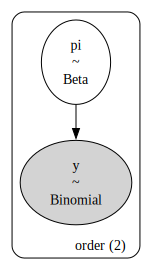

In [5]:
y = df_summary.head(2)["y"].to_numpy()
n = df_summary.head(2)["n"].to_numpy()

with pm.Model(coords={"order": [1, 2]}) as model:
    pi = pm.Beta("pi", alpha=4, beta=2, dims="order")
    y = pm.Binomial("y", p=pi, n=n, observed=y, dims="order")
    idata = pm.sample(chains=4, random_seed=1211, nuts_sampler="nutpie", progressbar=False)

model.to_graphviz()

Calculamos $\delta$ como la diferencia entre $\pi_2$ y $\pi_1$, y analizamos las distribuciones marginales *a posteriori*.

En primer lugar, los diagnósticos no indican problemas en el muestreo: $\hat{R}$ cercano a 1, tamaños efectivos de muestra adecuados, etc.

In [6]:
#| classes: .center-table-70
idata.posterior["delta"] = idata.posterior["pi"].sel(order=2) - idata.posterior["pi"].sel(order=1)
az.summary(idata, var_names=["pi", "delta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi[1],0.694,0.010,0.673,0.712,0.0,0.0,4040.0,2880.0,1.0
pi[2],0.754,0.011,0.733,0.773,0.0,0.0,3996.0,2737.0,1.0
delta,0.061,0.015,0.030,0.088,0.0,0.0,4193.0,2918.0,1.0


Si nos enfocamos en la distribución _a posteriori_ de $\delta$, podemos ver que la probabilidad de que $\delta$ sea mayor a 0 es igual a 1.

Así, llegamos a nuestra primera gran conclusión: efectivamente, la probabilidad de acertar en el segundo intento es mayor que en el primero.
De hecho, la probabilidad de acierto se incrementa, en promedio, un 6 %.
Y, con un alto grado de certeza, podemos afirmar que esta mejora se encuentra entre el 3 % y el 9 %.

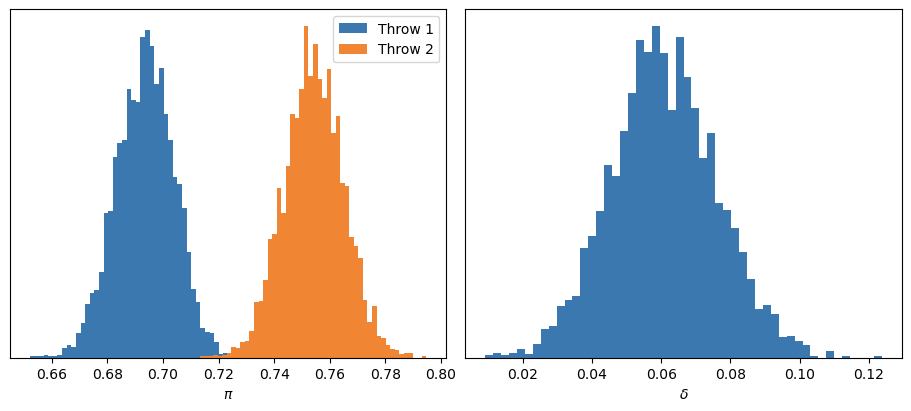

In [7]:
#| echo: false
fig, axes = plt.subplots(1, 2, figsize=(9, 4), layout="constrained")

axes[0].hist(idata.posterior.pi.sel(order=1).values.ravel(), bins=50, color=c_blue, label="Throw 1")
axes[0].hist(idata.posterior.pi.sel(order=2).values.ravel(), bins=50, color=c_orange, label="Throw 2")
axes[1].hist(idata.posterior.delta.values.ravel(), bins=50, color=c_blue)

axes[0].set(xlabel="$\\pi$", yticks=[])
axes[0].legend()
axes[1].set(xlabel="$\\delta$", yticks=[]);

## Modelo parcialmente agrupado

El modelo anterior solo nos permite concluir que es más probable que un _rookie_ acierte un segundo lanzamiento que un primero (y cuantificar la magnitud de la diferencia).
Sin embargo, no podemos extraer conclusiones sobre jugadores individuales.
Por ejemplo, no sabemos si este fenómeno de “precalentamiento” se presenta en todos ellos, ni si su intensidad varía de un jugador a otro.

Una alternativa sería ajustar pares de modelos beta-binomiales como los anteriores para cada jugador.
Lamentablemente, dado que la cantidad de disparos varía entre apenas uno y unas pocas centenas, las distribuciones _a posteriori_ pueden resultar extremadamente inciertas en algunos casos o excesivamente confiadas en otros.

Así llegamos a la alternativa bayesiana por excelencia: el modelo jerárquico.
Bajo este enfoque, cada jugador tiene su propia probabilidad de acierto, pero dicha probabilidad proviene de una distribución común compartida con el resto.
De este modo, las estimaciones son más estables y se evita el sobreajuste a los datos particulares de cada jugador, ya que la distribución *a posteriori* de cada uno está influenciada, en cierta medida, por la información del resto.

Los datos que necesitamos son la cantidad de disparos y aciertos en el primer y segundo intento para cada jugador.
Por simplicidad, consideramos únicamente a los jugadores que realizaron al menos una serie de dos tiros libres.

In [8]:
#| classes: .center-table-40
df_agg = (
    df
    .group_by("player_id", "order")
    .agg(
        pl.col("success").sum().alias("y"),
        pl.len().alias("n")
    )
    .sort("player_id", "order")
)
selected_ids = (
    df_agg
    .filter(pl.col("order") == 2, pl.col("n") > 0)
    .get_column("player_id")
    .unique()
    .to_list()
)

df_model = (
    df_agg
    .filter(pl.col("player_id").is_in(selected_ids), pl.col("order") < 3)
    .sort("player_id", "order")
)
df_model

player_id,order,y,n
i32,i64,u32,u32
1630283,1,1,5
1630283,2,5,5
1630542,1,4,5
1630542,2,4,5
1630545,1,9,12
…,…,…,…
1642502,2,1,2
1642505,1,1,1
1642505,2,1,1


De manera distribucional, podemos representar al modelo de la siguiente manera:

\begin{aligned}
Y_{i1} &\sim \text{Binomial}(N_{i1}, \pi_i) \\
Y_{i2} &\sim \text{Binomial}(N_{i2}, \theta_i) \\ \\

& \text{--- P(Free throw 1 is made) ---} \\

\pi_i &\sim \text{Beta}(\mu_\pi, \kappa_\pi) \\
\mu_\pi &\sim \text{Beta}(4, 2) \\
\kappa_\pi &\sim \text{InverseGamma}(0.5 \cdot 15, 0.5 \cdot 15 \cdot 10) \\ \\

& \text{--- P(Free throw 2 is made) --- } \\

\theta_i &= \pi_i + \delta_i \\
\delta_i &\sim \text{Normal}(\mu_\delta, \sigma^2_\delta) \\
\mu_\delta &\sim \text{Normal}(0, 0.15^2) \\
\sigma^2_\delta &\sim \text{InverseGamma}(0.5 \cdot 30, 0.5 \cdot 30 \cdot 0.05) \\
\end{aligned}


donde $i \in \{1, \dots, 92\}$ indexa a los jugadores.

En otras palabras, modelizamos la probabilidad de acierto en el segundo intento como la suma de la probabilidad de acierto en el primero ($\pi_i$) y un diferencial específico de cada jugador ($\delta_i$).

Las distribuciones _a priori_ para $\mu_\pi$ y $\mu_\delta$ son levemente y moderadamente informativas, respectivamente.
Por su parte, los _priors_ asignados a $\kappa_\pi$ y $\sigma^2_\delta$ también son moderadamente informativos, aunque en este caso su función principal es favorecer la estabilidad del muestreo del _posterior_.

In [9]:
y_1 = df_model.filter(pl.col("order") == 1)["y"].to_numpy()   # <1>
y_2 = df_model.filter(pl.col("order") == 2)["y"].to_numpy()   # <1>
n_1 = df_model.filter(pl.col("order") == 1)["n"].to_numpy()   # <1>
n_2 = df_model.filter(pl.col("order") == 2)["n"].to_numpy()   # <1>

player_ids = df_model["player_id"].unique(maintain_order=True) # <2>
N = len(player_ids)                                            # <2>
coords = {"player": player_ids}                                # <2>

with pm.Model(coords=coords) as model_h:
    pi_mu = pm.Beta("pi_mu", alpha=4, beta=2)                                     # <3>
    pi_kappa = pm.InverseGamma("pi_kappa", alpha=0.5 * 15, beta=0.5 * 15 * 10)    # <3>
    pi_alpha = pi_mu * pi_kappa                                                   # <3>
    pi_beta = (1 - pi_mu) * pi_kappa                                              # <3>
    pi = pm.Beta("pi", alpha=pi_alpha, beta=pi_beta, dims="player")               # <3>

    delta_mu = pm.Normal("delta_mu", mu=0, sigma=0.15)                                      # <4>
    delta_sigma = pm.InverseGamma("delta_sigma^2", 0.5 * 30, 0.5 * 30 * 0.05 ** 2) ** 0.5   # <4>
    delta = pm.Normal(                                                                      # <4>
        "delta", mu=delta_mu, sigma=delta_sigma, dims="player", initval=np.zeros(N)         # <5>
    )                                                                                       # <4>
    theta = pm.Deterministic("theta", pt.clip(pi + delta, 0.0001, 0.9999), dims="player")   # <6>
    # <4>

    pm.Binomial("y_1", p=pi, n=n_1, observed=y_1, dims="player")
    pm.Binomial("y_2", p=theta, n=n_2, observed=y_2, dims="player")

1. **Preparación de datos:** se usan vectores (se podrían haber usado arreglos bidimensionales).
2. **Preparación de coordenadas:** representan los diferentes jugadores.
3. **Construcción de $\pi_i$:** se asignan _priors_ para la media y la precisión, que luego se transforman en parámetros de escala para usados directamente en `pm.Beta`.
4. **Construcción de $\theta_i$:** se especifica, para cada jugador, un parámetro de diferencia $\delta_i$.
5. **Uso de `initval`:** para que el algoritmo de inferencia comience en un punto válido del espacio paramétrico.
6. **Uso de `pt.clip`:** para asegurarnos que $\pi_i + \delta_i$ se encuentre entre 0 y 1. Esto no afecta al _posterior_, pero es necesario para inicializar correctamente el algoritmo de muestreo.

Finalmente, así es como se ve una representación gráfica del modelo:

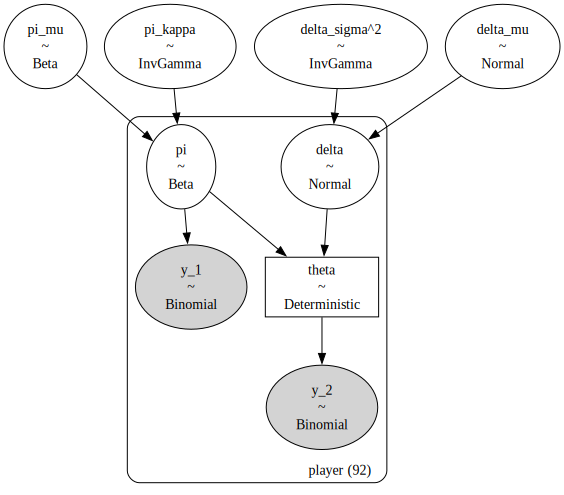

In [10]:
#| echo: false

# Regular data preparation. I could have used two bi-dimensional arrays, too.
# NOTE: Clip to guarantee theta is within the expected range, needed for initialization
model_h.to_graphviz()

Gracias a nutpie, es posible obtener muestras fiables del _posterior_ en muy pocos segundos.

Si bien los diagnósticos no se ven tan bien como en el modelo agrupado (lo cual es esperable en modelos jerárquicos), los valores son aceptables y podemos continuar con nuestro análisis.

In [11]:
#| classes: .center-table-70
with model_h:
    idata_h = pm.sample(
        chains=4,
        target_accept=0.99,
        nuts_sampler="nutpie",
        random_seed=1211,
        progressbar=False,
    )

az.summary(idata_h, var_names=["pi_mu", "pi_kappa", "delta_mu", "delta_sigma^2"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi_mu,0.698,0.015,0.670,0.727,0.000,0.000,1063.0,2206.0,1.00
pi_kappa,28.903,9.035,14.499,45.731,0.286,0.278,1001.0,1623.0,1.00
delta_mu,0.055,0.016,0.027,0.086,0.001,0.000,497.0,910.0,1.01
delta_sigma^2,0.002,0.001,0.001,0.003,0.000,0.000,1262.0,2006.0,1.00


Los _posteriors_ marginales de los parámetros poblacionales son los siguientes:

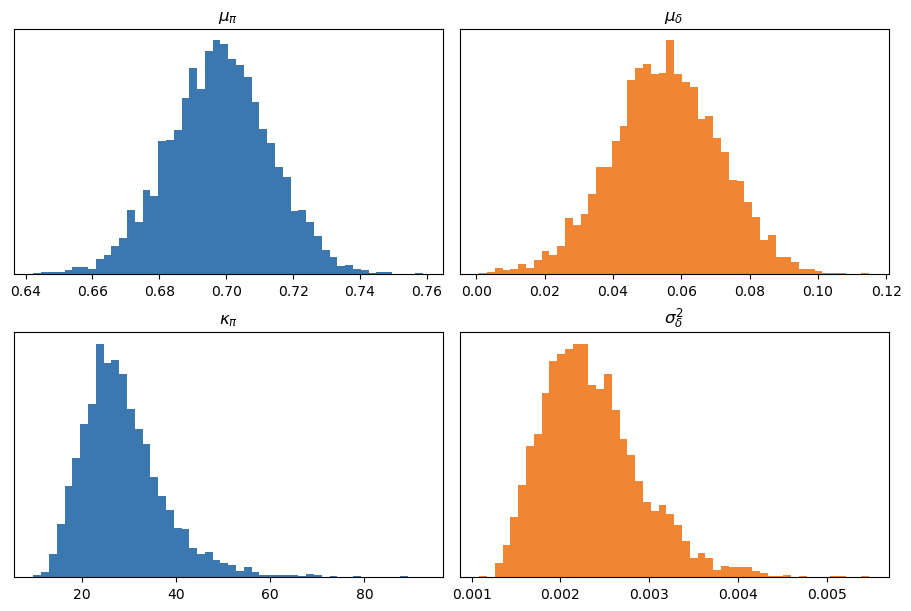

In [12]:
#| echo: false
fig, axes = plt.subplots(2, 2, figsize=(9, 6), layout="constrained")

axes[0, 0].hist(idata_h.posterior["pi_mu"].to_numpy().flatten(), bins=50, color=c_blue);
axes[1, 0].hist(idata_h.posterior["pi_kappa"].to_numpy().flatten(), bins=50, color=c_blue);
axes[0, 1].hist(idata_h.posterior["delta_mu"].to_numpy().flatten(), bins=50, color=c_orange);
axes[1, 1].hist(idata_h.posterior["delta_sigma^2"].to_numpy().flatten(), bins=50, color=c_orange);

axes[0, 0].set(yticks=[], title="$\\mu_{\\pi}$")
axes[1, 0].set(yticks=[], title="$\\kappa_{\\pi}$")
axes[0, 1].set(yticks=[], title="$\\mu_{\\delta}$")
axes[1, 1].set(yticks=[], title="$\\sigma^2_{\\delta}$");

A simple vista, se observa que, en promedio, la probabilidad de acertar un primer lanzamiento ronda el 70 %, y que los segundos intentos tienen, en promedio, cerca de un 6 % más de probabilidad de ser convertidos. Aunque esto no resulte novedoso, es satisfactorio comprobar que las inferencias obtenidas con el modelo jerárquico son consistentes con los hallazgos anteriores.

Lo realmente interesante de este modelo jerárquico es que nos permite analizar las distribuciones *a posteriori* de $\pi_i$, $\theta_i$ y $\delta_i$ a nivel individual, es decir, para cada jugador.

Sin embargo, visualizar estas distribuciones para todos ellos puede resultar poco práctico.
Por eso, seleccionamos un subconjunto representativo de jugadores en función de sus valores de $N_1$ (la cantidad de primeros lanzamientos).
En concreto, conservamos a los 10 jugadores con mayor $N_1$ y, entre el resto, los ordenamos de menor a mayor y elegimos uno cada dos posiciones para formar una muestra más manejable.

In [13]:
#| echo: false
#| classes: .center-table-60
df_selected_players = df_model.filter(pl.col("order") == 1).unique("n").sort("n")
players = df_selected_players.get_column("player_id").to_numpy()
players = np.concatenate([players[:(len(players ) - 10):2], players[-10:]])

player_mapping = []
for player in players:
    player_name = df.filter(pl.col("player_id") == player).get_column("player_name").unique().item()
    player_mapping.append({"player_id": player, "player_name": player_name})

df_player_mapping = pl.from_dicts(player_mapping)
with pl.Config(tbl_rows=30):
    display(
        df_model
        .filter(pl.col("player_id").is_in(players))
        .join(df_player_mapping, on="player_id")
        .pivot(on="order", index=["player_id", "player_name"], values=["y", "n"])
        .sort("n_1", descending=True)
    )

player_id,player_name,y_1,y_2,n_1,n_2
i32,str,u32,u32,u32,u32
1642264,"""Castle, Stephon""",128,121,192,152
1642274,"""Missi, Yves""",63,64,112,92
1642259,"""Sarr, Alex""",62,50,88,77
1642268,"""Collier, Isaiah""",56,49,85,69
1642258,"""Risacher, Zaccharie""",55,47,82,62
1642271,"""Filipowski, Kyle""",47,46,81,62
1641744,"""Edey, Zach""",54,36,76,51
1642377,"""Wells, Jaylen""",62,44,73,56
1641842,"""Holland II, Ronald""",51,41,70,52


Luego, podemos visualizar los *posterior* marginales de $\pi_i$, $\theta_i$ y $\delta_i$ para cada jugador seleccionado.
Naturalmente, a medida que aumenta la cantidad de disparos observados, las distribuciones *a posteriori* se vuelven más estrechas, reflejando un mayor nivel de certidumbre.

En todos los casos, incluso cuando $N_1 = 1$ y $N_2 = 1$, la media *a posteriori* de $\theta_i$ es mayor que la de $\pi_i$.

Visto desde otro ángulo, en el panel inferior se observa que la media de $\delta_i$ es siempre mayor que 0.
Sin embargo, solo en aquellos casos en los que se registran cientos de lanzamientos puede concluirse, con probabilidad cercana a 1, que los jugadores son efectivamente mejores en los segundos intentos que en los primeros.

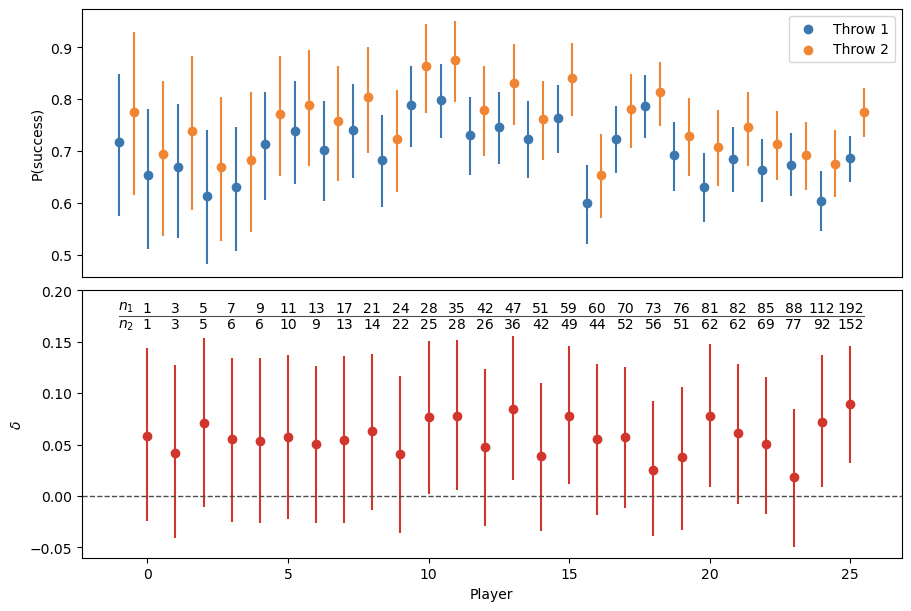

In [14]:
#| echo: false
posterior_players = idata_h.posterior.sel(player=players)
pi_mean = posterior_players["pi"].mean(("chain", "draw")).to_numpy()
pi_ci = posterior_players["pi"].quantile((0.05, 0.95), ("chain", "draw")).to_numpy()

theta_mean = posterior_players["theta"].mean(("chain", "draw")).to_numpy()
theta_ci = posterior_players["theta"].quantile((0.05, 0.95), ("chain", "draw")).to_numpy()

delta_mean = posterior_players["delta"].mean(("chain", "draw")).to_numpy()
delta_ci = posterior_players["delta"].quantile((0.05, 0.95), ("chain", "draw")).to_numpy()

x_label = (
    df_model
    .filter(pl.col("player_id").is_in(players))
    .pivot(on="order", index="player_id", values=["y", "n"])
    .sort("n_1")
    .with_columns(
        pl.concat_str(pl.col("n_1", "n_2"), separator = "\n").alias("label")
    )
    .get_column("label")
    .to_list()
)

x = np.arange(len(players))

fig, axes = plt.subplots(2, 1, figsize=(9, 6), layout="constrained")

axes[0].scatter(x - 0.25, pi_mean, color=c_blue, label="Throw 1")
axes[0].vlines(x - 0.25, pi_ci[0], pi_ci[1], color=c_blue)
axes[0].scatter(x + 0.25, theta_mean, color=c_orange, label="Throw 2")
axes[0].vlines(x + 0.25, theta_ci[0], theta_ci[1], color=c_orange)
axes[0].set(xticks=[], ylabel="P(success)")
axes[0].legend()


axes[1].scatter(x, delta_mean, color=c_red)
axes[1].vlines(x, delta_ci[0], delta_ci[1], color=c_red)
axes[1].axhline(0, ls="--", color="0.3", lw=1)
axes[1].set(xlabel="Player", ylabel="$\\delta$", ylim=[-0.06, 0.20]);

for x_i, x_l in zip(x, x_label):
    axes[1].text(x_i, 0.175, x_l, size=10, ha="center", va="center")

axes[1].plot([-1, 25.5], [0.175, 0.175], lw=0.8, color="0.3")

axes[1].text(-0.75, 0.175, "$n_1$\n$n_2$", size=10, ha="center", va="center");

Como somos bayesianos y utilizamos métodos de Markov Chain Monte Carlo para obtener muestras del *posterior*, podemos calcular, para cada jugador, la probabilidad de que $\delta_i$ sea mayor que 0.
Con estas probabilidades, es posible construir el siguiente histograma resumen:

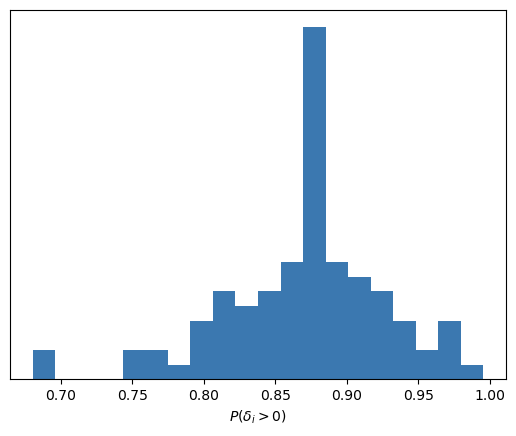

In [15]:
#| echo: false
fig, ax = plt.subplots()
p_delta = (idata_h.posterior["delta"] > 0).mean(("chain", "draw")).to_numpy()
ax.hist(p_delta, bins=20, color=c_blue)
ax.set(yticks=[], xlabel="$P(\\delta_i > 0)$");

Luego, sin importar el *rookie* en el que nos fijemos, siempre concluiremos que tiene una probabilidad entre moderada y alta de ser más efectivo en los segundos lanzamientos que en los primeros.

Para finalizar, comparemos la distribución *a posteriori* de $\delta$ del modelo agrupado con el *posterior* de $\mu_\delta$ del modelo parcialmente agrupado, ya que ambas representan la misma cantidad: el diferencial promedio en la probabilidad de acierto entre un segundo y un primer lanzamiento.

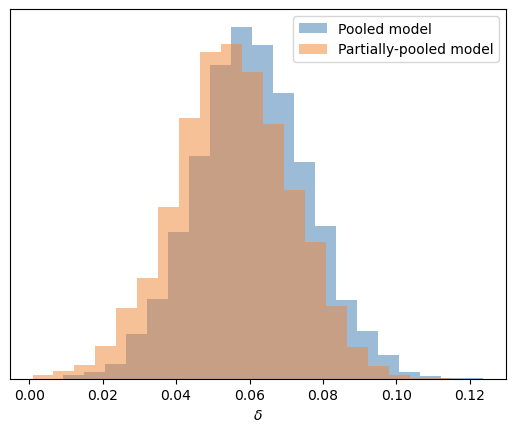

In [16]:
#| echo: false
fig, ax = plt.subplots()

delta_1 = idata.posterior["delta"].to_numpy().flatten()
delta_2 = idata_h.posterior["delta_mu"].to_numpy().flatten()

ax.hist(delta_1, bins=20, color=c_blue, alpha=0.5, label="Pooled model")
ax.hist(delta_2, bins=20, color=c_orange, alpha=0.5, label="Partially-pooled model")
ax.set(yticks=[], xlabel="$\\delta$")
ax.legend();

Afortunadamente, no tenemos que reportar sorpresas. Ambos modelos nos conducen hacia conclusiones prácticamente similares sobre el $\delta$ promedio, aunque se puede mencionar que en el modelo jerárquico el _posterior_ se encuentra levemente más regularizado hacia el 0 que en el modelo agrupado. Sin embargo, no debemos olvidar que utilizar un modelo jerárquico nos permitió obtener distribuciones _a posteriori_ para cada jugador individual.

## Comentarios finales

Ejemplos como este son los que me recuerdan por qué el enfoque bayesiano para la modelización estadística me gusta tanto.

Si bien podríamos habernos conformado con una simple prueba de hipótesis, como la que presentan en el [artículo mencionado](https://link.springer.com/article/10.1007/s12662-020-00646-x),
la flexibilidad que ofrecen herramientas como PyMC nos permite ir varios pasos más allá.
Propusimos un modelo jerárquico (nada trivial), lo implementamos en PyMC, y luego este, junto con nutpie, se encargaron de proporcionarnos muestras del _posterior_.

A partir de esas muestras, pudimos extraer varias conclusiones interesantes.
No solo aquellas a nivel global, que confirman que los jugadores de básquet suelen fallar más en los primeros disparos que en los segundos (en línea con los resultados del artículo),
sino también conclusiones específicas para cada jugador.

Y, por encima de todo, más allá de la utilidad práctica del modelo o de los _insights_ que podamos obtener… ¿no es acaso super divertido jugar a la estadística bayesiana?